In [1]:
%matplotlib inline

In [2]:
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import os
import sys
import re

In [4]:
import numpy as np
from scipy.io import wavfile
import tensorflow as tf

## Load custom libraries

In [5]:
import config as cfg
from dataload import load_data
from preprocessing import signalProcessBatch

## Tensorflow setup

In [6]:
# Tensorflow setup
sess = None
tf.logging.set_verbosity(tf.logging.INFO)

def reset_vars():
    """Initializes all tf variables"""
    sess.run(tf.global_variables_initializer())

def reset_tf():
    """Closes the current tf session and opens new session"""
    global sess
    if sess:
        sess.close()
    tf.reset_default_graph()
    sess = tf.Session()

## Load some audio training files to test

In [7]:
df = load_data(cfg.DATA_DIR)

In [8]:
df_train = df[df.setlabel == 'train']

In [9]:
df_train.head(10)

,filepath,label,uid,uversion,setlabel,reqlabel,reqlabelflag
0,right/988e2f9a_nohash_0.wav,right,988e2f9a,0,train,right,True
1,right/1eddce1d_nohash_3.wav,right,1eddce1d,3,train,right,True
2,right/93ec8b84_nohash_0.wav,right,93ec8b84,0,train,right,True
3,right/6272b231_nohash_1.wav,right,6272b231,1,train,right,True
5,right/2f813234_nohash_1.wav,right,2f813234,1,train,right,True
6,right/b87bdb22_nohash_1.wav,right,b87bdb22,1,train,right,True
9,right/51055bda_nohash_4.wav,right,51055bda,4,train,right,True
10,right/fac74f6a_nohash_1.wav,right,fac74f6a,1,train,right,True
11,right/a8cb6dda_nohash_0.wav,right,a8cb6dda,0,train,right,True
12,right/e4a2cf79_nohash_0.wav,right,e4a2cf79,0,train,right,True


In [10]:
# Weights to allow for larger numbers of unknowns
weights = np.where(df_train.reqlabelflag, 1.0, 1850. / 32550.)

In [11]:
# Select a random sample of files
batch_size = 100
df_train_batch = df_train.sample(n=batch_size, weights=weights)

In [12]:
X_list = df_train_batch.filepath
y_label = df_train_batch.reqlabel

In [13]:
X = np.zeros([batch_size, cfg.SAMRATE])
for i, f in enumerate(X_list):
    sr, wave = wavfile.read(os.path.join(cfg.DATA_DIR, 'train', 'audio', f))
    wave.resize(16000)
    X[i] += wave

In [14]:
X.shape

(100, 16000)

In [35]:
reset_tf()

In [46]:
# Note that noise_factor=0 is faster than setting add_noise=False
#%timeit -r 1 -n 1
mfccs, mel_spectrograms, zcr, rmse = sess.run(signalProcessBatch(X, add_noise=True, noise_factor=0.1,
                                                                 window=512, maxamps=cfg.MAXAMPS, sr=16000,
                                                                 num_mel_bins=64, num_mfccs=13))

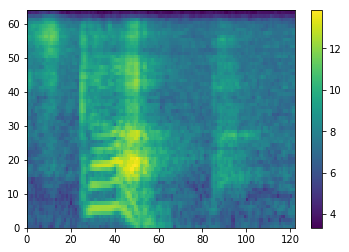

In [38]:
# No Noise
plt.pcolormesh(mel_spectrograms[50].T)
plt.colorbar();

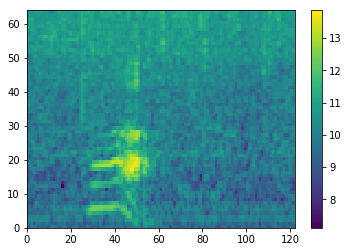

In [47]:
# With added noise from NOISE_MATRIX, noise_factor=0.1
plt.pcolormesh(mel_spectrograms[50].T)
plt.colorbar();

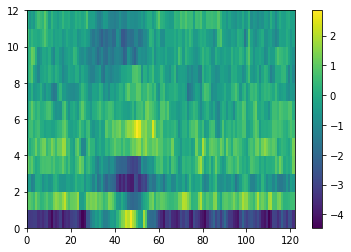

In [48]:
# With added noise from NOISE_MATRIX, noise_factor=0.1
plt.pcolormesh(mfccs[50].T[1:])
plt.colorbar();

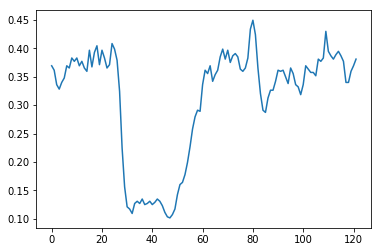

In [51]:
plt.plot(zcr[50]);

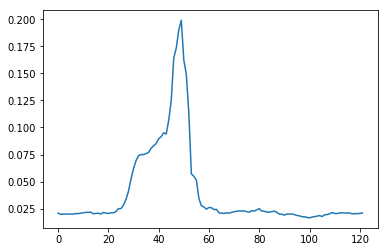

In [52]:
plt.plot(rmse[50]);

## Wrap file batch load into function